# Predicción con LSTM

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import KFold
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, Callback
from IPython.display import clear_output
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Trabajo en Google Colab
with open('/content/dfs.pkl', 'rb') as archivo:
    dfs = pickle.load(archivo)

In [4]:
len(dfs)

28

In [5]:
dfs[0].shape, dfs[0]

((347, 16),
 array([[0.7915103647248436, 0.2555500694510472, 0.7699380974337213, ...,
         False, False, False],
        [0.7865745330835447, 0.25505673403305545, 0.7747280572181771, ...,
         False, False, False],
        [0.783257652522349, 0.2498766661455021, 0.7779860729045281, ...,
         False, False, False],
        ...,
        [0.6364856902165876, 0.4375924946410434, 0.6253294989385919, ...,
         False, False, False],
        [0.6408687134853148, 0.49037984435256066, 0.6271023396941757, ...,
         False, False, False],
        [0.6467127411407548, 0.5022200093809627, 0.6308854307720998, ...,
         False, False, False]], dtype=object))

In [6]:
# Dividir en subsecuencias
def split_sequences(sequences, n_steps_in, n_steps_out):
  X = list()
  y = list()
  for split in sequences:
    for i in range(0, len(split), n_steps_out):
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
      if out_end_ix > len(split):
        break
      else:
        seq_x = split[i:end_ix]
        seq_y = split[end_ix-1:out_end_ix, 0] # battery
      X.append(seq_x)
      y.append(seq_y)
  return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')

In [7]:
seed = 0

In [8]:
# Definir modelo
def create_lstm_model(n_steps_in, n_features, n_steps_out):
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(n_steps_out, activation='sigmoid'))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])
  return model

Vamos a predecir 6*12 valores, es decir 12h adelante, y vamos a tomar como base el mismo número de valores.

## 12h

In [9]:
n_steps_in = 6*12
n_steps_out = 6*12
print(n_steps_in, n_steps_out)

72 72


In [10]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [11]:
X[0][0]

array([0.79151034, 0.25555006, 0.7699381 , 0.23867734, 0.        ,
       0.23443224, 0.04786121, 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [13]:
num_folds = 5

loss_per_fold = []
mae_per_fold = []
mape_per_fold = []
cs_per_fold = []
history_per_fold = []

# K-fold Cross Validation
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X, y):
  # Crear modelo
  model = create_lstm_model(n_steps_in, n_features, n_steps_out)
  print('------------------------------------------------------------------------')
  print(f'Entrenando fold {fold_no} ...')
  # Entrenar modelo
  history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=100, callbacks=[
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])
  # Evaluar modelo
  loss, mae, mape, cs = model.evaluate(X[test], y[test])
  # Guardar datos
  loss_per_fold.append(loss)
  mae_per_fold.append(mae)
  mape_per_fold.append(mape)
  cs_per_fold.append(cs)
  history_per_fold.append(history)
  # Guardamos modelo
  model.save(f'/content/lstm-12h-fold{fold_no}.keras')
  fold_no += 1
  # Limpiamos output
  clear_output(wait=True)

# Medias
print('------------------------------------------------------------------------')
print('Puntuaciones por fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 4)} - MAE: {round(mae_per_fold[i],4)} - MAPE: {round(mape_per_fold[i],4)} - CS: {round(cs_per_fold[i],4)}')
print('------------------------------------------------------------------------')
print('Medias de todos los folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> MAE: {np.mean(mae_per_fold)}')
print(f'> MAPE: {np.mean(mape_per_fold)}')
print(f'> CS: {np.mean(cs_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Puntuaciones por fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0073 - MAE: 0.0543 - MAPE: 14708.6084 - CS: 0.9934
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0105 - MAE: 0.0676 - MAPE: 16.8973 - CS: 0.9904
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0073 - MAE: 0.0536 - MAPE: 12.1274 - CS: 0.9937
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0121 - MAE: 0.08 - MAPE: 25.6393 - CS: 0.9895
------------------------------------------------------------------------
> Fold 5 - Loss: 0.009 - MAE: 0.0625 - MAPE: 13.7773 - CS: 0.9924
------------------------------------------------------------------------
Medias de todos los folds:
> Loss: 0.009233097080141306
> MAE: 0.0636257454752922
> MAPE: 2955.4099393844604
> CS: 0.991884684562683

In [20]:
# Mejor fold
best_fold = loss_per_fold.index(min(loss_per_fold)) + 1
print("Mejor fold:", best_fold)

model = load_model(f'/content/lstm-12h-fold{best_fold}.keras')

Mejor fold: 3


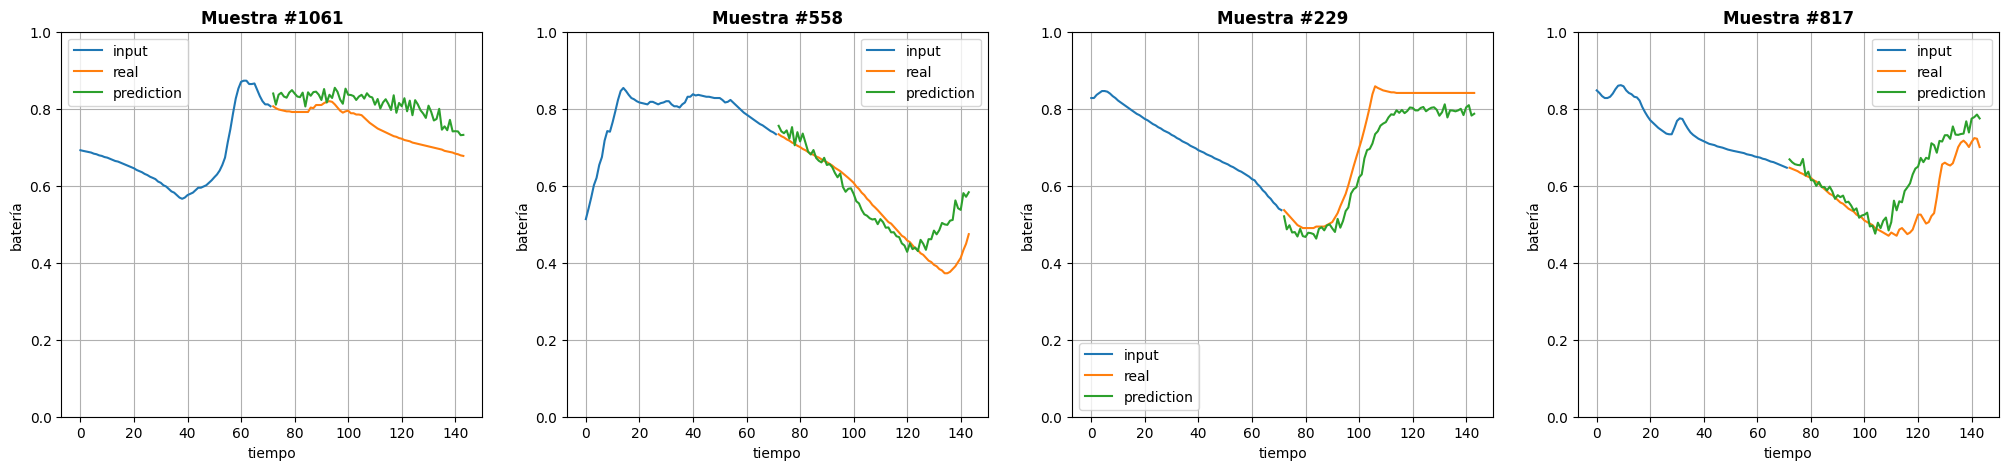

In [30]:
# Predicciones mostradas gráficamente del mejor modelo
f, axs = plt.subplots(1,4, figsize=(25, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X))
  yhat = model.predict(X[item].reshape(1, X[item].shape[0], X[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('tiempo')
  ax.set_ylabel('batería')
  ax.set_title(f'Muestra #{item}', fontweight='600')
  ax.legend()
  ax.grid()
plt.show()

Vamos a hacer lo mismo con 6h y 24h.
## 6h

In [31]:
n_steps_in = n_steps_out = 6*6
print(n_steps_in, n_steps_out)

36 36


In [32]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [33]:
num_folds = 5

loss_per_fold = []
mae_per_fold = []
mape_per_fold = []
cs_per_fold = []
history_per_fold = []

# K-fold Cross Validation
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X, y):
  # Crear modelo
  model = create_lstm_model(n_steps_in, n_features, n_steps_out)
  print('------------------------------------------------------------------------')
  print(f'Entrenando fold {fold_no} ...')
  # Entrenar modelo
  history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=100, callbacks=[
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])
  # Evaluar modelo
  loss, mae, mape, cs = model.evaluate(X[test], y[test])
  # Guardar datos
  loss_per_fold.append(loss)
  mae_per_fold.append(mae)
  mape_per_fold.append(mape)
  cs_per_fold.append(cs)
  history_per_fold.append(history)
  # Guardamos modelo
  model.save(f'/content/lstm-6h-fold{fold_no}.keras')
  fold_no += 1
  # Limpiamos output
  clear_output(wait=True)

# Medias
print('------------------------------------------------------------------------')
print('Puntuaciones por fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 4)} - MAE: {round(mae_per_fold[i],4)} - MAPE: {round(mape_per_fold[i],4)} - CS: {round(cs_per_fold[i],4)}')
print('------------------------------------------------------------------------')
print('Medias de todos los folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> MAE: {np.mean(mae_per_fold)}')
print(f'> MAPE: {np.mean(mape_per_fold)}')
print(f'> CS: {np.mean(cs_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Puntuaciones por fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0068 - MAE: 0.0503 - MAPE: 33.8333 - CS: 0.9955
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0089 - MAE: 0.0625 - MAPE: 14.4485 - CS: 0.9932
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0086 - MAE: 0.0632 - MAPE: 5891.4463 - CS: 0.9945
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0058 - MAE: 0.0471 - MAPE: 10.4992 - CS: 0.9963
------------------------------------------------------------------------
> Fold 5 - Loss: 0.005 - MAE: 0.0447 - MAPE: 9.2763 - CS: 0.9967
------------------------------------------------------------------------
Medias de todos los folds:
> Loss: 0.006994084641337395
> MAE: 0.053550292551517484
> MAPE: 1191.9007396697998
> CS: 0.9952417135238

In [34]:
# Mejor fold
best_fold = loss_per_fold.index(min(loss_per_fold)) + 1
print("Mejor fold:", best_fold)

model = load_model(f'/content/lstm-6h-fold{best_fold}.keras')

Mejor fold: 5


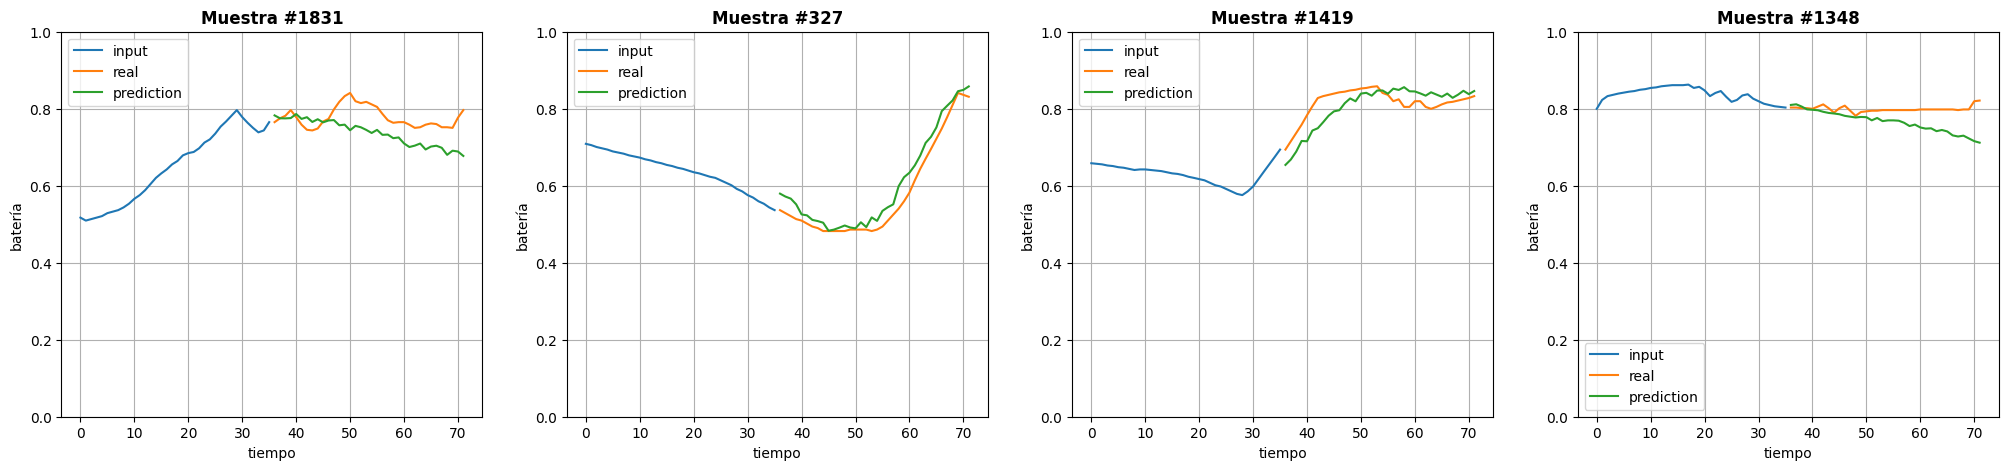

In [35]:
# Predicciones mostradas gráficamente del mejor modelo
f, axs = plt.subplots(1,4, figsize=(25, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X))
  yhat = model.predict(X[item].reshape(1, X[item].shape[0], X[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('tiempo')
  ax.set_ylabel('batería')
  ax.set_title(f'Muestra #{item}', fontweight='600')
  ax.legend()
  ax.grid()
plt.show()

## 24h

In [36]:
n_steps_in = n_steps_out = 6*24
print(n_steps_in, n_steps_out)

144 144


In [37]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [38]:
num_folds = 5

loss_per_fold = []
mae_per_fold = []
mape_per_fold = []
cs_per_fold = []
history_per_fold = []

# K-fold Cross Validation
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X, y):
  # Crear modelo
  model = create_lstm_model(n_steps_in, n_features, n_steps_out)
  print('------------------------------------------------------------------------')
  print(f'Entrenando fold {fold_no} ...')
  # Entrenar modelo
  history = model.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=100, callbacks=[
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])
  # Evaluar modelo
  loss, mae, mape, cs = model.evaluate(X[test], y[test])
  # Guardar datos
  loss_per_fold.append(loss)
  mae_per_fold.append(mae)
  mape_per_fold.append(mape)
  cs_per_fold.append(cs)
  history_per_fold.append(history)
  # Guardamos modelo
  model.save(f'/content/lstm-24h-fold{fold_no}.keras')
  fold_no += 1
  # Limpiamos output
  clear_output(wait=True)

# Medias
print('------------------------------------------------------------------------')
print('Puntuaciones por fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 4)} - MAE: {round(mae_per_fold[i],4)} - MAPE: {round(mape_per_fold[i],4)} - CS: {round(cs_per_fold[i],4)}')
print('------------------------------------------------------------------------')
print('Medias de todos los folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> MAE: {np.mean(mae_per_fold)}')
print(f'> MAPE: {np.mean(mape_per_fold)}')
print(f'> CS: {np.mean(cs_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Puntuaciones por fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0096 - MAE: 0.0621 - MAPE: 16.9618 - CS: 0.9911
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0436 - MAE: 0.182 - MAPE: 28.2952 - CS: 0.9795
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0086 - MAE: 0.06 - MAPE: 27088.6504 - CS: 0.9898
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0093 - MAE: 0.0619 - MAPE: 24.8919 - CS: 0.9902
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0076 - MAE: 0.0541 - MAPE: 14.8648 - CS: 0.9891
------------------------------------------------------------------------
Medias de todos los folds:
> Loss: 0.01575345452874899
> MAE: 0.08399818167090416
> MAPE: 5434.732823562622
> CS: 0.9879266738891601

In [39]:
# Mejor fold
best_fold = loss_per_fold.index(min(loss_per_fold)) + 1
print("Mejor fold:", best_fold)

model = load_model(f'/content/lstm-24h-fold{best_fold}.keras')

Mejor fold: 5


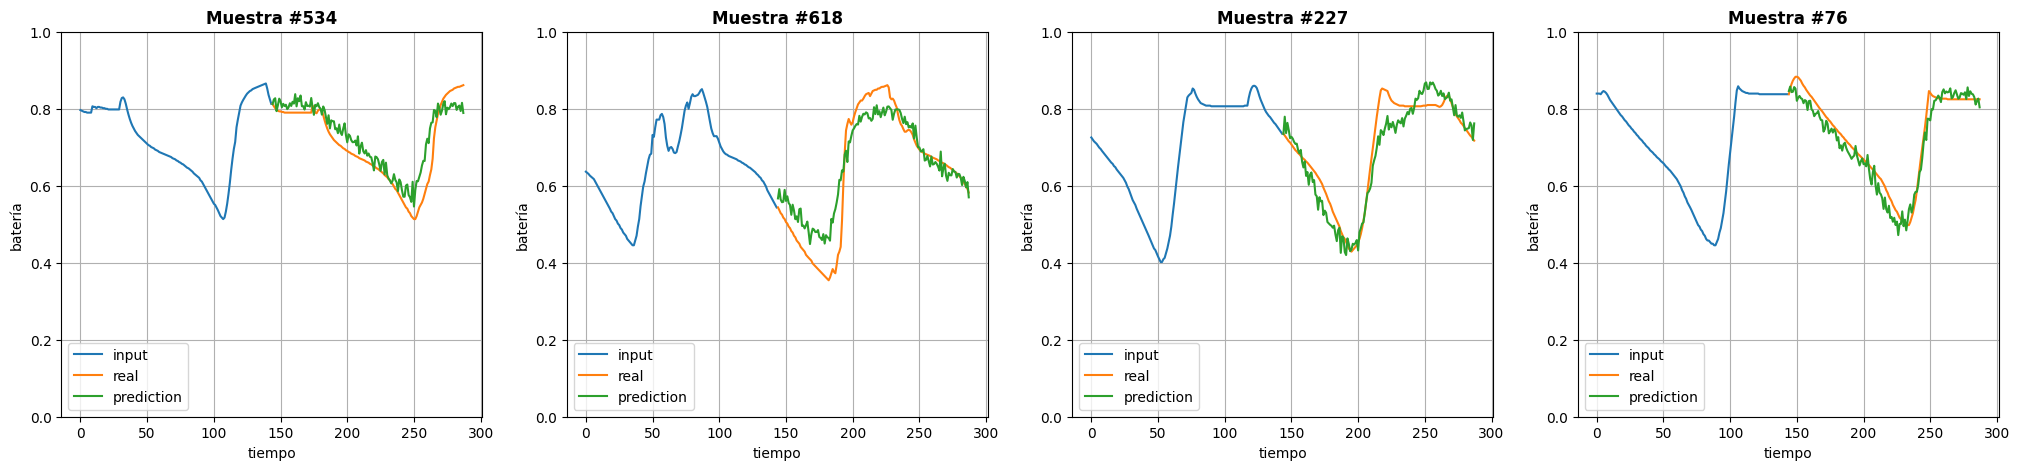

In [43]:
# Predicciones mostradas gráficamente del mejor modelo
f, axs = plt.subplots(1,4, figsize=(25, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X))
  yhat = model.predict(X[item].reshape(1, X[item].shape[0], X[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('tiempo')
  ax.set_ylabel('batería')
  ax.set_title(f'Muestra #{item}', fontweight='600')
  ax.legend()
  ax.grid()
plt.show()